In [1]:
import numpy as np
import os
import torch,torchvision
import copy
from mask2former.utils.misc import is_dist_avail_and_initialized, nested_tensor_from_tensor_list
import pickle
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
# y, _= nested_tensor_from_tensor_list(x).decompose()

/home/rana/anaconda3/envs/m2f/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


coco_lvis_2017_train datset registered
Berkeley data registered
/home/rana/Thesis/DynaMITe/datasets/GrabCut
davis_2017_val datset registered


/home/rana/anaconda3/envs/m2f/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
list(range(1,3))

[1, 2]

# Summarising multi-instance evaluation

In [14]:
_root_dir = os.path.join(os.getcwd(), "output/evaluations/")

In [15]:
pickle_path = _root_dir + "sbd_multi_insts/mq_baseline_mit_b0_bs32_ep50_per_obj_02_03_2023_21_20_33__10.pickle"
with open(pickle_path, 'rb') as handle:
    b= pickle.load(handle)

In [17]:
print(f"dataset: {b['dataset']}")
print(f"iou_threshold: {b['iou_threshold']}")
print(f"NOC: {b['Avg_NOC']}")
print(f"NCI: {b['avg_over_total_images']}")
print(f"NFO: {b['num_failed_objects']}")
print(f"failed_images_counts: {b['failed_images_counts']}")

dataset: sbd_multi_insts
iou_threshold: 0.85
NOC: 6.02
NCI: 4.056120028223635
NFO: 1747
failed_images_counts: 847


In [20]:
ids = list(b["ious_objects_per_interaction"].keys())
ids[:10]

['2008_000003_0',
 '2008_000007_1',
 '2008_000009_2',
 '2008_000027_3',
 '2008_000043_4',
 '2008_000051_5',
 '2008_000059_6',
 '2008_000067_7',
 '2008_000073_8',
 '2008_000075_9']

In [28]:
b["ious_objects_per_interaction"]['2008_000067_7']

[[tensor(0.8549), tensor(0.9158)],
 [tensor(0.8549), tensor(0.9158)],
 [tensor(0.8549), tensor(0.9158)],
 [tensor(0.8549), tensor(0.9158)],
 [tensor(0.8549), tensor(0.9158)]]

In [29]:
b["clicked_objects_per_interaction"]['2008_000067_7']

[[True, True, True],
 [True, False, False],
 [False, False, True],
 [True, False, False],
 [False, False, True]]

In [2]:
ious = [torch.tensor(0.8549), torch.tensor(0.9158)]

In [4]:
num_times_point_smapled_false = 0
while True:
    if all(iou >= 0.85 for iou in ious) or num_times_point_smapled_false >= 2:
        break
    print(1)

In [18]:
ids = list(b["ious_objects_per_interaction"].keys())
total_iou_change = 0
count = 0
bins = 101
neg_iou_change = [0]*bins
pos_iou_change = [0]*bins

neg_iou_change_bg = [0]*bins
pos_iou_change_bg = [0]*bins
bg_clicks = 0
fg_clicks = 0
for key in ids:
    ious = np.asarray(b["ious_objects_per_interaction"][key])
    clicked = b["clicked_objects_per_interaction"][key]
    indices = [sum(i)>=1 for i in clicked]
    clicked = np.asarray(clicked)[indices] 
    if len(indices)<len(ious):
        indices.append(False)
    
    ious = ious[indices]
    assert len(ious) == len(clicked)
    
    for i in range(1,len(clicked)):
        if len(ious[i])==1:
            continue
        diff = (ious[i]-ious[i-1])*100
        t = np.where(clicked[i]==True)[0][0]
        if t== len(clicked[i])-1: #bg_click
            bg_clicks+=1
            for d in diff:
                if d>0:
                   pos_iou_change_bg[int(abs(d))]+=1
                elif d<0:
                   neg_iou_change_bg[int(abs(d))]+=1 
        else:
            # diff[t] = 0
            fg_clicks+=1
            for (i, d) in enumerate(diff):
                if i!=t:
                    if d>0:
                        pos_iou_change[int(abs(d))]+=1
                    elif d<0:
                        neg_iou_change[int(abs(d))]+=1 

        # # print(diff)
        # total_iou_change += (sum(diff)*100/(len(diff)-1))
        # count+=1    

In [19]:
print(f'fg_clicks: {fg_clicks}\n')
print(f'negative iou change(>=3%) : {sum(neg_iou_change[3:])}\n')
print(f'positive iou change(>=3%) : {sum(pos_iou_change[3:])}\n')

print(f'bg_clicks: {bg_clicks}\n')
print(f'negative iou change bg(>=3%) : {sum(neg_iou_change_bg[3:])}\n')
print(f'positive iou change bg(>=3%) : {sum(pos_iou_change_bg[3:])}')


fg_clicks: 26738

negative iou change(>=3%) : 0

positive iou change(>=3%) : 0

bg_clicks: 5659

negative iou change bg(>=3%) : 0

positive iou change bg(>=3%) : 0


In [13]:
print(neg_iou_change)
sum(neg_iou_change[3:])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0

In [2]:
def g(x):
    print("x_g",x)
    x+=1
    print("x_g_",x)

def f(x):

    for i in range(5):
        g(x)
        x+=1

In [3]:
f(0)

x_g 0
x_g_ 1
x_g 1
x_g_ 2
x_g 2
x_g_ 3
x_g 3
x_g_ 4
x_g 4
x_g_ 5


In [8]:
model = torch.load("weights/segformer/mit_b0_trans.pth")

In [ ]:
model.keys()

In [5]:
price = [5,3,2,10]
# max_from_last= [0]*len(price)
# max_from_last[-1] = price[-1]
_max = price[-1]
profit = 0
for i in range(len(price)-2,-1,-1):
    _max= max(price[i], _max)
    profit += (_max-price[i])
profit


20

In [2]:
a = " backbone.bottom_up.patch_embed1.proj.{bias, weight}"

In [3]:
a.lstrip(' ').replace(".bottom_up", "")

'backbone.patch_embed1.proj.{bias, weight}'

In [75]:
import sys
a = torch.ones((1024,1024)).to(dtype=torch.float)
sys.getsizeof(a)

64

In [73]:
a.shape

torch.Size([1024, 1024])

In [153]:
from detectron2.projects.point_rend.point_features import (
    get_uncertain_point_coords_with_randomness,
    point_sample,
)


In [7]:
import torch.nn.functional as F
a = torch.zeros((10,10))
a[0:6,0:3] = 1
a[4:7,4:7] = 1
# a[0:5, 7:] =1
a

tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
p = torch.stack(torch.where(a), dim=1).to(torch.float)
p

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [2., 0.],
        [2., 1.],
        [2., 2.],
        [3., 0.],
        [3., 1.],
        [3., 2.],
        [4., 0.],
        [4., 1.],
        [4., 2.],
        [4., 4.],
        [4., 5.],
        [4., 6.],
        [5., 0.],
        [5., 1.],
        [5., 2.],
        [5., 4.],
        [5., 5.],
        [5., 6.],
        [6., 4.],
        [6., 5.],
        [6., 6.]])

In [187]:
p = torch.stack(torch.where(a), dim=1).to(torch.float)
p[:,0]/=float(1024)
p[:,1]/=float(1024)


In [10]:
x = torch.ones((1,5,3))
x.mean(2).shape

torch.Size([1, 5])

In [190]:
y = point_sample(x, p.unsqueeze(0))

/home/rana/anaconda3/envs/m2f/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [201]:
a = [[[1,2,0]]*3, [[4,5,0]]*4, [[6,6,1]]*5]
a

[[[1, 2, 0], [1, 2, 0], [1, 2, 0]],
 [[4, 5, 0], [4, 5, 0], [4, 5, 0], [4, 5, 0]],
 [[6, 6, 1], [6, 6, 1], [6, 6, 1], [6, 6, 1], [6, 6, 1]]]

In [202]:
y = copy.deepcopy(a[0])
for t in a[1:]:
    y.extend(t)
y

[[1, 2, 0],
 [1, 2, 0],
 [1, 2, 0],
 [4, 5, 0],
 [4, 5, 0],
 [4, 5, 0],
 [4, 5, 0],
 [6, 6, 1],
 [6, 6, 1],
 [6, 6, 1],
 [6, 6, 1],
 [6, 6, 1]]

In [208]:
t = torch.tensor(y)[:,:2]

In [209]:
t.per

tensor([[1, 2],
        [1, 2],
        [1, 2],
        [4, 5],
        [4, 5],
        [4, 5],
        [4, 5],
        [6, 6],
        [6, 6],
        [6, 6],
        [6, 6],
        [6, 6]])

In [204]:
a

[[[1, 2, 0], [1, 2, 0], [1, 2, 0]],
 [[4, 5, 0], [4, 5, 0], [4, 5, 0], [4, 5, 0]],
 [[6, 6, 1], [6, 6, 1], [6, 6, 1], [6, 6, 1], [6, 6, 1]]]

In [175]:
p = torch.zeros((len(torch.where(a)[0]),2))
p.shape

torch.Size([41, 2])

In [101]:
x = F.interpolate(a.unsqueeze(0).unsqueeze(0), size=(128,128), mode="bilinear", align_corners=True)
x

tensor([[[[1., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [145]:
from scipy import ndimage
import numpy as np
a = np.arange(16.).reshape((4, 4))
a

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]])

In [140]:
a.T

array([[ 0.,  4.,  8., 12.],
       [ 1.,  5.,  9., 13.],
       [ 2.,  6., 10., 14.],
       [ 3.,  7., 11., 15.]])

In [146]:
ndimage.map_coordinates(a, [[1], [0.5, 1]], order=1, mode='nearest')

array([4.5, 5. ])

In [143]:
from scipy.ndimage.interpolation import map_coordinates
# from mpl_toolkits.basemap import interp
import numpy

in_data = numpy.array([[ 25.89125824,  25.88840675],[ 25.90930748,  25.90640068]], dtype=numpy.float32)

in_data.shape



/tmp/ipykernel_17552/3095995108.py:1: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


(2, 2)

In [150]:
map_coordinates(a, [[1.7,1.5], [1,1.5]], order=1, mode='nearest')

array([7.8, 7.5])

In [40]:
import cv2
num_labels, labels_im = cv2.connectedComponents(a.astype(np.uint8))

In [47]:
labels_im

array([[1, 1, 1, 0, 0, 0, 0, 2, 2, 2],
       [1, 1, 1, 0, 0, 0, 0, 2, 2, 2],
       [1, 1, 1, 0, 0, 0, 0, 2, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 2, 2, 2],
       [0, 0, 0, 0, 3, 3, 0, 2, 2, 2],
       [0, 0, 0, 0, 3, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [45]:
np.bincount(labels_im.flat)

array([72,  9, 15,  4])

In [ ]:
labels_im == np.argmax(np.bincount(labels_im.flat)[1:]) + 1

In [ ]:
from mask2former.data.dataset_mappers.eval.davis17_sbd_mq_evaluation_clicks_mapper import DAVIS17SBDEvalMQClicksDatasetMapper

In [6]:
from mask2former.data.datasets.register_coco_lvis import *
from detectron2.data import DatasetCatalog, MetadataCatalog

_root = os.getcwd()
_root = os.path.join(_root, "datasets/")
# _root = os.getenv("DETECTRON2_DATASETS", "datasets")
# print(_root)
# register_all_coco_lvis_2017(_root)

In [ ]:
d = DatasetCatalog.get("coco_lvis_2017_train")

In [10]:
ious = np.array([.76,.78,.80,.82,.85,.87,.90])

In [11]:
vals = ious>=.80
vals

array([False, False,  True,  True,  True,  True,  True])

In [12]:
np.argmax(vals)

2

In [5]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
print("date and time =", dt_string +"s")

now = 2023-02-08 10:36:37.880132
date and time = 08_02_2023_10_36_37s


In [3]:
list(range(5,-1,-1))

[5, 4, 3, 2, 1, 0]

In [7]:
a = [1,2,3]
10 in a

False

In [81]:
x = torch.randn((2,5,5))
torch.argmax(x,0)

tensor([[0, 1, 0, 1, 1],
        [0, 0, 0, 1, 1],
        [1, 1, 1, 0, 1],
        [1, 0, 1, 0, 0],
        [1, 0, 1, 1, 0]])

In [65]:
x = torch.randn(10, dtype=torch.float32, requires_grad=True)
print(x)
y = x.repeat(5, 1)
z = (y**2).sum()
# z.backward()
torch.autograd.backward([z], inputs=[x])

tensor([-0.2960,  0.8196, -1.1057, -0.7486,  0.0711, -1.1511, -0.5144, -0.5536,
         1.3287, -0.3221], requires_grad=True)


In [ ]:
optim = torch.optim.SGD([x], lr=0.01)
print(x)        # tensor([1., 2.], requires_grad=True)
optim.step()
print(x)  

In [ ]:
y

In [49]:
x = torch.randn(3, 4, requires_grad=True)
print(x)
# def test_repeat(x):
y = x.repeat(2, 2, 2, 2)
out = y.sum()
out.backward()

# test_repeat(x)

tensor([[-0.0929,  1.6599,  0.0832,  0.5620],
        [-0.3079,  2.0893, -1.9158,  1.1371],
        [-0.5511, -0.2064,  0.6665,  0.4380]], requires_grad=True)


In [50]:
optim = torch.optim.SGD([x], lr=0.001)
print(x)        # tensor([1., 2.], requires_grad=True)
optim.step()
print(x)  

tensor([[-0.0929,  1.6599,  0.0832,  0.5620],
        [-0.3079,  2.0893, -1.9158,  1.1371],
        [-0.5511, -0.2064,  0.6665,  0.4380]], requires_grad=True)
tensor([[-0.1089,  1.6439,  0.0672,  0.5460],
        [-0.3239,  2.0733, -1.9318,  1.1211],
        [-0.5671, -0.2224,  0.6505,  0.4220]], requires_grad=True)


In [20]:
x = np.ones((5,5),dtype=np.bool_)
x

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [16]:
y = np.ones((5,5))
y[2:4,1:4] =0
y

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1.]])

In [17]:
s = np.argwhere(y)

In [18]:
import random
indices = random.sample(range(s.shape[0]),5)

In [19]:
indices

[9, 3, 16, 8, 10]

In [20]:
from functools import lru_cache
@lru_cache(maxsize=None)
def generate_probs(max_num_points, gamma):
    probs = []
    last_value = 1
    for i in range(max_num_points):
        probs.append(last_value)
        last_value *= gamma

    probs = np.array(probs)
    probs /= probs.sum()

    return probs

In [21]:
pos_probs = generate_probs(5,gamma=0.7)
pos_probs

array([0.36060726, 0.25242508, 0.17669756, 0.12368829, 0.0865818 ])

In [78]:
x = [[1,2,0], [2,3]]
y = []
y.append(x[1].append(0))
y


[None]

In [79]:
import math
use_timestamp=False
def gen_sineembed_for_position(pos_tensor):
    # n_query, bs, _ = pos_tensor.size()
    # sineembed_tensor = torch.zeros(n_query, bs, 256)
    import math
    scale = 2 * math.pi
    dim_t = torch.arange(128, dtype=torch.float32, device=pos_tensor.device)
    dim_t = 10000 ** (2 * torch.div(dim_t, 2, rounding_mode='floor') / 128)
    x_embed = pos_tensor[:, :, 0] * scale
    y_embed = pos_tensor[:, :, 1] * scale
    if use_timestamp:
        t_embed = pos_tensor[:, :, 2] * scale
        y_embed += t_embed
        x_embed += x_embed
    pos_x = x_embed[:, :, None] / dim_t
    pos_y = y_embed[:, :, None] / dim_t
    pos_x[:, :, 0::2][torch.where(pos_x[:, :, 0::2] < 0)] = 0.0
    pos_x[:, :, 1::2][torch.where(pos_x[:, :, 1::2] < 0)] = (0.5 * math.pi)
    pos_y[:, :, 0::2][torch.where(pos_y[:, :, 0::2] < 0)] = 0.0
    pos_y[:, :, 1::2][torch.where(pos_y[:, :, 1::2] < 0)] = (0.5 * math.pi)
    pos_x = torch.stack((pos_x[:, :, 0::2].sin(), pos_x[:, :, 1::2].cos()), dim=3).flatten(2)
    pos_y = torch.stack((pos_y[:, :, 0::2].sin(), pos_y[:, :, 1::2].cos()), dim=3).flatten(2)
    pos = torch.cat((pos_y, pos_x), dim=2)
    return pos

In [80]:
def get_pos_tensor_coords(batched_fg_coords_list, batched_bg_coords_list, num_queries, height, width, device):

    #batched_fg_coords_list: batch x (list of list of fg coords) [y,x,t]

    # return
    # points: Bs x num_queries x 3 
    B = len(batched_fg_coords_list)
    
    pos_tensor = []
    
    for i, fg_coords_per_image in enumerate(batched_fg_coords_list):
        coords_per_image  = []
        for fg_coords_per_mask in fg_coords_per_image:
            for coords in fg_coords_per_mask:
                coords_per_image.append([coords[0]/width, coords[1]/height, coords[2]])
        if batched_bg_coords_list[i] is not None:
            for coords in batched_bg_coords_list[i]:
                coords_per_image.append([coords[0]/width, coords[1]/height, coords[2]])
        coords_per_image.extend([[-1.0,-1.0,-1.0]] * (num_queries-len(coords_per_image)))
        pos_tensor.append(torch.tensor(coords_per_image,device=device))
    # pos_tensor = torch.tensor(pos_tensor,device=device)
    pos_tensor = torch.stack(pos_tensor)
    return pos_tensor

In [81]:
# [y,x,t]
batched_fg_coords_list = [[[[2,3,0],[3,5,0]], [[5,6,0], [6,7,0]]], [[[2,3,0],[3,5,0]], [[5,6,0], [6,7,0]]]]
batched_bg_coords_list = [[[6,7,0]],None]
num_queries = 11
height = width = 50
device = 'cpu'

pos_tensor = get_pos_tensor_coords(batched_fg_coords_list, batched_bg_coords_list, num_queries, height, width, device)


In [82]:
pos_tensor.shape

torch.Size([2, 11, 3])

In [83]:
pos_tensor

tensor([[[ 0.0400,  0.0600,  0.0000],
         [ 0.0600,  0.1000,  0.0000],
         [ 0.1000,  0.1200,  0.0000],
         [ 0.1200,  0.1400,  0.0000],
         [ 0.1200,  0.1400,  0.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000]],

        [[ 0.0400,  0.0600,  0.0000],
         [ 0.0600,  0.1000,  0.0000],
         [ 0.1000,  0.1200,  0.0000],
         [ 0.1200,  0.1400,  0.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000]]])

In [86]:
scale = 2 * math.pi
dim_t = torch.arange(128, dtype=torch.float32, device=pos_tensor.device)
dim_t = 10000 ** (2 * torch.div(dim_t, 2, rounding_mode='floor') / 128)
x_embed = pos_tensor[:, :, 0] * scale
y_embed = pos_tensor[:, :, 1] * scale
# if use_timestamp:
#     t_embed = pos_tensor[:, :, 2] * scale
#     y_embed += t_embed
#     x_embed += x_embed
pos_x = x_embed[:, :, None] / dim_t
pos_y = y_embed[:, :, None] / dim_t
pos_x = torch.stack((pos_x[:, :, 0::2].sin(), pos_x[:, :, 1::2].cos()), dim=3).flatten(2)
pos_y = torch.stack((pos_y[:, :, 0::2].sin(), pos_y[:, :, 1::2].cos()), dim=3).flatten(2)
pos = torch.cat((pos_y, pos_x), dim=2)


In [87]:
pos_x = x_embed[:, :, None] / dim_t
pos_x.shape

torch.Size([2, 11, 128])

In [88]:
pos_x[:, :, 0::2][torch.where(pos_x[:, :, 0::2] < 0)] = 0.0
pos_x[:, :, 1::2][torch.where(pos_x[:, :, 1::2] < 0)] = math.pi * 0.5

In [90]:
pos_x[:, :, 1::2].cos()

tensor([[[ 9.6858e-01,  9.7641e-01,  9.8229e-01,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 9.2978e-01,  9.4718e-01,  9.6030e-01,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 8.0902e-01,  8.5559e-01,  8.9104e-01,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         ...,
         [-4.3711e-08, -4.3711e-08, -4.3711e-08,  ..., -4.3711e-08,
          -4.3711e-08, -4.3711e-08],
         [-4.3711e-08, -4.3711e-08, -4.3711e-08,  ..., -4.3711e-08,
          -4.3711e-08, -4.3711e-08],
         [-4.3711e-08, -4.3711e-08, -4.3711e-08,  ..., -4.3711e-08,
          -4.3711e-08, -4.3711e-08]],

        [[ 9.6858e-01,  9.7641e-01,  9.8229e-01,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 9.2978e-01,  9.4718e-01,  9.6030e-01,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 8.0902e-01,  8.5559e-01,  8.9104e-01,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         ...,
         [-4.3711e-08, -4

In [84]:
p_t = gen_sineembed_for_position(pos_tensor)

In [85]:
p_t

tensor([[[ 3.6812e-01,  9.2978e-01,  3.2069e-01,  ...,  1.0000e+00,
           2.9023e-05,  1.0000e+00],
         [ 5.8779e-01,  8.0902e-01,  5.1765e-01,  ...,  1.0000e+00,
           4.3534e-05,  1.0000e+00],
         [ 6.8455e-01,  7.2897e-01,  6.0751e-01,  ...,  1.0000e+00,
           7.2557e-05,  1.0000e+00],
         ...,
         [ 0.0000e+00, -4.3711e-08,  0.0000e+00,  ..., -4.3711e-08,
           0.0000e+00, -4.3711e-08],
         [ 0.0000e+00, -4.3711e-08,  0.0000e+00,  ..., -4.3711e-08,
           0.0000e+00, -4.3711e-08],
         [ 0.0000e+00, -4.3711e-08,  0.0000e+00,  ..., -4.3711e-08,
           0.0000e+00, -4.3711e-08]],

        [[ 3.6812e-01,  9.2978e-01,  3.2069e-01,  ...,  1.0000e+00,
           2.9023e-05,  1.0000e+00],
         [ 5.8779e-01,  8.0902e-01,  5.1765e-01,  ...,  1.0000e+00,
           4.3534e-05,  1.0000e+00],
         [ 6.8455e-01,  7.2897e-01,  6.0751e-01,  ...,  1.0000e+00,
           7.2557e-05,  1.0000e+00],
         ...,
         [ 0.0000e+00, -4

In [94]:
math.cos(math.pi/2)

6.123233995736766e-17

In [52]:
x = [[0,0,0]]*5
x = torch.tensor(x)
torch.stack((x,x)).shape

torch.Size([2, 5, 3])

In [ ]:
import torchvision.transforms.functional as F
def visualization(batched_inputs, prev_output, batched_fg_coords_list,batched_bg_coords_list,
                  alpha_blend=0.6, num_iter = 0):
    image = np.asarray(batched_inputs[0]['image'].permute(1,2,0))

    visualizer = Visualizer(image, metadata=None)
    if prev_output is not None:
        pred_masks = F.resize(prev_output.pred_masks.to(dtype=torch.uint8), image.shape[:2])
    else:
        pred_masks = batched_inputs[0]['instances'].gt_masks
    c = []
    for i in range(pred_masks.shape[0]):
        # c.append(color_map[2*(i)+2]/255.0)
        c.append(color_map[i]/255.0)
    # pred_masks = np.asarray(pred_masks).astype(np.bool_)
    vis = visualizer.overlay_instances(masks = pred_masks, assigned_colors=c, alpha=alpha_blend)
    # [Optional] prepare labels

    image = vis.get_image()
    # # Laminate your image!
    total_colors = len(color_map)-1
    
    h,w = image.shape[:2]
    for fg_coords_per_mask in batched_fg_coords_list[0]:
        for i, coords in enumerate(fg_coords_per_mask):
            color = np.array(color_map[total_colors-5*i-4], dtype=np.uint8)
            if i==0:
                image = cv2.circle(image, (int(coords[1]), int(coords[0])), 8, color, -1)
            else:
                image = cv2.circle(image, (int(coords[1]), int(coords[0])), 3, color, -1)
    
    if batched_bg_coords_list[0]:
         for i, coords in enumerate(batched_bg_coords_list[0]):
            color = np.array([255,0,0], dtype=np.uint8)
            image = cv2.circle(image, (int(coords[1]), int(coords[0])), 3, color, -1)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # image = cv2.resize(image, (inputs["width"],inputs["height"]))
    save_dir = os.path.join("./train_vis/", str(batched_inputs[0]['image_id']))
    os.makedirs(save_dir, exist_ok=True)
    cv2.imwrite(os.path.join(save_dir, f"iter_{num_iter}.jpg"), image)

In [4]:
x = torch.ones((5,5),dtype=torch.bool)
x

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]])

In [5]:
x = x.to(torch.uint8)
x

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]], dtype=torch.uint8)

False

In [50]:
import pickle
with open("datasets/lvis/coco_lvis_combined_panoptic_1half.pickle", 'rb') as f:
    dataset_dicts = pickle.load(f)

with open("datasets/lvis/coco_lvis_combined_panoptic_2half.pickle", 'rb') as f:
    dataset_dicts1 = pickle.load(f)

dataset_dicts.extend(dataset_dicts1)

In [51]:
with open("datasets/lvis/coco_lvis_combined_panoptic.pickle", 'wb') as handle:
    pickle.dump(dataset_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
len(dataset_dicts)

99354

In [1]:
import pickle

with open("output/GrabCut_points_dict_16_02_2023_14_38_32_.pickle", 'rb') as f:
    pt_sampled_dict = pickle.load(f)

with open("output/GrabCut_points_dict_16_02_2023_14_39_07_.pickle", 'rb') as f:
    pt_sampled_dict1 = pickle.load(f)

# with open("output/features_dicts1_GrabCut.pickle", 'rb') as f:
#     features_dict1 = pickle.load(f)


In [2]:
len(pt_sampled_dict)

50

In [ ]:
pt_sampled_dict1.items()

In [3]:
sum_p = 0
for k,v in pt_sampled_dict.items():
    sum_p+= len(v)
sum_p/50

1.66

In [4]:
sum_p = 0
for k,v in pt_sampled_dict1.items():
    sum_p+= len(v)
sum_p/50

1.66

In [6]:
for k in pt_sampled_dict.keys():
    for k1 in pt_sampled_dict1.keys():
        if k==k1 and pt_sampled_dict[k]!=pt_sampled_dict1[k1]:
            print(k)
            print(pt_sampled_dict1[k1])
            print(pt_sampled_dict[k]) 

In [13]:
with open("output/GrabCut_features_dict_16_02_2023_14_51_57_.pickle", 'rb') as f:
    features_dict = pickle.load(f)

with open("output/GrabCut_features_dict_16_02_2023_14_53_59_.pickle", 'rb') as f:
    features_dict1 = pickle.load(f)

In [ ]:
import torch
for k in features_dict.keys():
    for k1 in features_dict1.keys():
        if (k==k1):
            print(torch.all(features_dict[k]['first_mask_before_resize']==features_dict1[k1]['first_mask_before_resize']))
            # print(k)

In [46]:
features_dict.keys()

dict_keys(['bool', 'grave', '326038', 'banana1', 'book', 'memorial', 'banana2', 'bush', 'doll', 'person6', '86016', 'person3', 'person2', '227092', '209070', '21077', 'scissors', 'teddy', '65019', '271008', 'flower', 'person5', '189080', 'person8', 'sheep', '388016', '69020', 'person7', 'banana3', '37073', 'person1', '124080', '153077', 'music', '106024', 'cross', 'fullmoon', 'tennis', 'elefant', 'stone1', 'llama', '208001', 'stone2', '304074', '153093', 'ceramic', '24077', 'person4', '376043', '181079'])

In [15]:
features_dict['bush']['sem_seg_head.predictor.query_embed']


KeyError: 'sem_seg_head.predictor.query_embed'

In [16]:
import torch
torch.all(features_dict['bush']['sem_seg_head.predictor.query_embed']==features_dict['bool']['sem_seg_head.predictor.query_embed'])

tensor(True, device='cuda:0')

In [13]:
from torch import nn
query_embed = nn.Parameter(torch.zeros(256), True)

In [14]:
nn.init.normal_(query_embed)

Parameter containing:
tensor([-6.4749e-01, -9.4622e-01,  9.9136e-01, -2.8006e-01, -1.1464e+00,
         2.3682e+00, -1.9174e+00,  4.9042e-01, -1.7973e+00, -8.8009e-02,
         2.9536e-01, -1.1632e+00,  7.8763e-01,  9.7209e-02, -4.6051e-01,
        -1.3793e+00, -1.3135e+00, -8.6194e-01, -2.2053e+00,  1.6569e+00,
         5.3033e-01,  2.0219e+00,  1.4238e+00, -2.7438e-01, -2.9316e-01,
         5.7328e-01, -4.8293e-01,  4.7248e-01, -4.7783e-01, -9.5518e-01,
         3.4036e-02,  6.3088e-01, -1.7732e-03,  3.7992e-01, -1.1083e+00,
        -2.0908e+00, -5.4316e-01,  3.8153e-01, -2.4660e+00, -7.5894e-01,
         1.7062e-01, -6.1475e-01,  1.0703e+00,  3.5325e-01,  2.6061e-01,
        -3.5651e-01,  4.8227e-01,  7.7621e-01,  9.3742e-01, -1.3908e+00,
         1.1140e+00,  7.4399e-01, -4.4368e-01,  1.0445e+00, -1.4251e+00,
         1.7776e-01, -5.6139e-01,  1.3463e+00,  1.2909e+00,  1.0224e+00,
         1.0126e-02, -3.6532e-01,  3.0054e-01, -1.0427e+00, -2.5550e+00,
         1.3792e+00, -3.0180e

In [6]:
q = features_dict1['bool']['sem_seg_head.predictor.query_embed']

In [7]:
q

tensor([ 5.4440e-01, -3.9581e-01,  1.4902e+00,  5.7210e-01,  1.4115e+00,
         1.1782e+00,  1.7427e-01,  7.7683e-01,  1.3897e+00,  1.3905e-01,
         1.0957e-01, -1.4464e-01, -1.5933e+00,  1.4587e+00, -1.1386e+00,
         4.5302e-01,  5.3029e-01,  1.9542e-01,  1.1081e+00, -7.5916e-01,
         9.3200e-01, -4.5756e-01, -1.4237e+00,  4.0218e-01, -9.7000e-01,
         8.2498e-01,  4.8588e-01, -7.4774e-01, -5.4895e-01,  1.4943e+00,
         1.6388e+00, -1.4993e+00,  9.8590e-01, -3.4655e-01, -5.1271e-01,
         2.0943e-01, -1.9139e+00, -8.3778e-02,  6.0873e-01, -1.1971e+00,
        -1.0011e+00,  7.8411e-01,  1.2188e+00, -6.9305e-01, -1.8274e-02,
         7.3414e-01,  6.8789e-03,  2.3990e-02,  5.2682e-01,  7.5319e-01,
         4.7599e-02, -4.8743e-01,  1.9112e-01, -7.5404e-01,  1.4807e+00,
        -2.0128e+00, -1.5868e+00,  1.2303e+00,  1.5168e-01, -1.4823e+00,
        -3.3540e-01, -5.1541e-01,  1.8677e-01, -1.3345e+00,  1.0651e+00,
         1.5484e-01,  2.3708e-01,  9.4255e-01, -8.8

In [8]:
nn.init.normal_(q)

NameError: name 'nn' is not defined

In [32]:
p = torch.where(features_dict['bush']['first_mask_before_resize']!=features_dict1['bush']['first_mask_before_resize'])

In [1]:
import torch
import torch.nn as nn

class GaussianModel(nn.Module):

    def __init__(self):
        super(GaussianModel, self).__init__()

        self.register_parameter('mean', nn.Parameter(torch.zeros(1),True))
        
        # self.pdf = torch.distributions.Normal(self.mean,
                                            #   torch.tensor([1.0]))
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.normal_(self.mean)

    def forward(self, x):
        pdf = torch.distributions.Normal(self.mean,
                                              torch.tensor([1.0]))
        return -pdf.log_prob(x)

model = GaussianModel()

/home/rana/anaconda3/envs/m2f/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [85]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)
for _ in range(5):
  optimizer.zero_grad()
  nll = model(torch.tensor([3.0], requires_grad=True))
  nll.backward()
  optimizer.step()
  print('mean : ', model.mean.item(),
                 ' - Negative Loglikelihood : ', nll.item())

mean :  0.7252676486968994  - Negative Loglikelihood :  3.51652193069458
mean :  0.7298170924186707  - Negative Loglikelihood :  3.5061421394348145
mean :  0.734357476234436  - Negative Loglikelihood :  3.4958038330078125
mean :  0.7388887405395508  - Negative Loglikelihood :  3.485507011413574
mean :  0.7434109449386597  - Negative Loglikelihood :  3.475250720977783


In [86]:
# torch.save(model, 'gauss.pth')
torch.save(model.state_dict(), 'gauss.pth')

In [91]:
model = torch.load('gauss.pth')

In [94]:
model.keys()

odict_keys(['mean'])

In [87]:
model = GaussianModel()

In [88]:
model.state_dict()

OrderedDict([('mean', tensor([-0.0619]))])

In [89]:
model.load_state_dict(torch.load('gauss.pth'))

<All keys matched successfully>

In [90]:
model.state_dict()

OrderedDict([('mean', tensor([0.7434]))])

In [15]:
from iterative_train_net import Trainer
from mask2former import COCOMultiInstStuffMultiQueriesClicksDatasetMapper, add_maskformer2_config, COCOLVISMultiInstMQClicksDatasetMapper
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from mask2former.utils.equal_num_instances_batch import build_detection_train_loader_equal
from detectron2.checkpoint import DetectionCheckpointer

cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
# cfg.merge_from_file("mycfg.yaml")
# /home/rana/claix_work/DynaMITe/configs/coco_lvis/resnet/multi_queries_stufff_clicks_R50_bs32_ep50.yaml
cfg.merge_from_file("output/mq_coco_swin_tiny_bs32_ep50/config.yaml")

model_path = "output/single_inst_mq_per_obj_coco_swin_tiny_bs32_ep50/model_final.pth"
model = Trainer.build_model(cfg)

# DetectionCheckpointer(model, save_dir="output/").resume_or_load(
#             model_path, resume=False
#         )

# model = model['model']
# model.eval()
model.load_state_dict(torch.load(cfg.MODEL.WEIGHTS)["model"])
# model = torch.load(cfg.MODEL.WEIGHTS)['model']

<All keys matched successfully>

In [ ]:
model.state_dict()

In [4]:
model['model']["sem_seg_head.predictor.query_embed"]

tensor([-0.0491,  0.1466, -0.5566, -0.8277,  0.0337, -0.4834,  0.6618, -0.2049,
        -0.0588,  0.2471,  0.4428,  0.5744,  0.2546,  0.5237,  1.0650,  1.2559,
        -0.5063, -0.7054, -0.5026,  0.3244,  0.3879,  0.5603, -0.3371, -0.9213,
         1.0746,  0.7930, -0.1447, -0.2350, -0.5455, -0.3754, -0.5877,  0.8867,
        -0.2563,  0.5760,  0.0996, -0.7674,  0.7588,  0.2343, -0.5574, -0.9866,
        -0.7541,  0.3442,  0.3891, -0.1894,  0.2952,  0.0716, -0.2876, -0.3046,
         0.4605, -0.6726,  0.1304, -0.2660,  0.0327,  0.4801,  0.3427,  1.3805,
         0.5639, -0.4341,  0.7380,  0.4367, -0.4625, -0.5704, -0.1120, -0.1216,
         0.0056, -0.2250, -0.6623, -0.0103, -0.4091,  0.3360, -0.1978,  0.8804,
         0.1445, -0.0618,  0.5945,  0.0445, -0.9692, -0.4574, -1.4822, -0.0275,
        -1.5009, -0.3918, -0.6106,  1.2462,  0.3436,  0.2367, -0.8787, -0.2510,
         0.2018, -0.1357,  0.1206,  1.1781, -0.1904, -0.2060, -0.2927, -0.1783,
        -0.8082,  0.3542, -0.7496, -0.55

In [ ]:
max_objs = 0
num_objs = []
for d in dataset_dicts:
    max_objs = max(max_objs, len(d['annotations']))
    num_objs.append(len(d['annotations']))
# len(dataset_dicts[0]['annotations'])
max_objs

421

In [7]:
with open("datasets/lvis/coco_lvis_combined_panoptic.pickle", 'wb') as handle:
    pickle.dump(dataset_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open("datasets/lvis/coco_lvis_combined_panoptic.pickle", 'rb') as f:
    dataset_dicts = pickle.load(f)

len(dataset_dicts)

99354

In [6]:
from mask2former import COCOMultiInstStuffMultiQueriesClicksDatasetMapper, add_maskformer2_config, COCOLVISMultiInstMQClicksDatasetMapper
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from mask2former.utils.equal_num_instances_batch import build_detection_train_loader_equal
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
# cfg.merge_from_file("mycfg.yaml")
# /home/rana/claix_work/DynaMITe/configs/coco_lvis/resnet/multi_queries_stufff_clicks_R50_bs32_ep50.yaml
cfg.merge_from_file("configs/coco_lvis/resnet/multi_queries_stufff_clicks_R50_bs32_ep50.yaml")

mapper = COCOLVISMultiInstMQClicksDatasetMapper(cfg,True)
data_loader =  build_detection_train_loader_equal(cfg, mapper=mapper)

Found pickle file:datasets/lvis/coco_lvis_combined_panoptic.pickle


In [9]:
batch = next(iter(data_loader))

In [18]:
from mask2former.utils.vis import get_visualization
x = batch[14]
get_visualization(x)

In [114]:
x = torch.tensor([True,True,False])
x =torch.stack([x,x])
print(x.shape)
y = torch.tensor([0.4,-0.5,1])
torch.stack([y],0).shape

torch.Size([2, 3])


torch.Size([1, 3])

In [47]:
from torch import nn
x = nn.Parameter(torch.zeros(2,5), True)
x

Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)

In [48]:
nn.init.xavier_uniform_(x)

Parameter containing:
tensor([[ 0.9249,  0.0939, -0.0056, -0.2211,  0.0067],
        [-0.8090,  0.0233, -0.8762, -0.4058,  0.8678]], requires_grad=True)

In [49]:
x

Parameter containing:
tensor([[ 0.9249,  0.0939, -0.0056, -0.2211,  0.0067],
        [-0.8090,  0.0233, -0.8762, -0.4058,  0.8678]], requires_grad=True)

In [86]:
mask = np.zeros((5,5))
mask[0:4,1:5]=1
mask

array([[0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.]])

In [87]:
import cv2
mask = np.pad(mask, ((1, 1), (1, 1)), 'constant')
dt = cv2.distanceTransform(mask.astype(np.uint8), cv2.DIST_L2, 0)[1:-1, 1:-1]
print(dt)
max_dist = np.max(dt)
coords_y, coords_x = np.where(dt == max_dist)
print(coords_y[0], coords_x[0])

[[0. 1. 1. 1. 1.]
 [0. 1. 2. 2. 1.]
 [0. 1. 2. 2. 1.]
 [0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]
1 2


In [77]:
import random
random.seed(1243456)
indices = random.sample(range(candidates.shape[0]),1)
indices

[3]

In [ ]:
torch.where(x['padding_mask'])

In [15]:
batch[0]['instances'].gt_masks.shape

torch.Size([2, 512, 512])

In [16]:
import cv2
import numpy as np
image = np.asarray(x["image"].permute(1,2,0))
cv2.imshow("img_window",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [17]:
image = np.asarray(x["instances"].gt_masks[0])
cv2.imshow("img_window",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
x["instances"].gt_masks[0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [16]:
i=1
x=1
while(True):
    if x==1:
        break
    i+=1
    x+=1

In [2]:
import torch
a = torch.zeros((10,20,20))
b = torch.zeros((10,20,5))
torch.cat((a,b),dim=2).shape                                                                    

/home/rana/anaconda3/envs/m2f/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([10, 20, 25])

In [15]:
def fun(x,y):
    x.append(5)
    y.append(6)
    return x,y
a = [4]
b = [6]
(a,
b) = fun(a,b)
print(a,b)

[4, 5] [6, 6]


In [9]:
a = np.array([1,1.0,0], dtype=np.bool_)
a.sum()

2

In [7]:
a = torch.tensor([1.,2.], requires_grad=True)
b = torch.tensor([2.,3.], requires_grad=True)  
ab = torch.cat((a,b), dim=0) # ab  = tensor([1., 2., 2., 3.], grad_fn=<CatBackward>)
z = ab**2 # z = tensor([1., 4., 4., 9.], grad_fn=<PowBackward0>)
out = z.mean() # out = tensor(4.5000, grad_fn=<MeanBackward0>)
out.backward()
print(a.grad) # tensor([1.5000, 2.5000])
b.grad # tensor([1.5000, 2.5000])

tensor([0.5000, 1.0000])


tensor([1.0000, 1.5000])

In [1]:
from detectron2.evaluation import inference_on_dataset


In [42]:
import pickle
file_path = "all_data/evaluations/sbd_multi_insts/dynamite_swin_tiny_1024_bs64_10_max_click_th_final_updated_time_summary.pickle"

with open(file_path, 'rb') as handle:
    b = pickle.load(handle)
b.keys()

In [198]:
k = ['dataset', 'model', 'iou_threshold', 'failed_images_counts', 'avg_over_total_images', 'Avg_NOC', 'Avg_IOU', 'num_failed_objects']

In [58]:
b['Avg_NOC']

4.48

In [55]:
6671/2857

2.334966748337417

In [50]:
times = b['time_per_image_features']

In [51]:
sum(times)/len(times)

0.14331715965665856

In [52]:
times = b['time_per_image_annotation']
sum(times)/len(times)

0.6641665849995062

In [53]:
times = b['time_per_intreaction_tranformer_decoder']
sum(times)/len(times)

0.038640099109417216

In [59]:
0.038*2.33*4.48 + 0.14


0.5366592

In [228]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["num interactions", "NCI", "NOC", "NFO", "NFI"]
for i in range(6):
    file_path = f"all_data/evaluations/sbd_multi_insts/ablation_iter_{i}_10_max_click_th_final_updated_time_summary.pickle"

    with open(file_path, 'rb') as handle:
        b = pickle.load(handle)
    
    x.add_row([i, np.round(b['avg_over_total_images'],2), b['Avg_NOC'], b['num_failed_objects'], b['failed_images_counts']])


In [229]:
print(x)

+------------------+------+------+------+-----+
| num interactions | NCI  | NOC  | NFO  | NFI |
+------------------+------+------+------+-----+
|        0         | 3.94 | 5.24 | 2024 | 928 |
|        1         | 3.87 | 5.16 | 1854 | 884 |
|        2         | 3.67 | 4.9  | 1682 | 825 |
|        3         | 3.63 | 4.8  | 1566 | 778 |
|        4         | 3.51 | 4.69 | 1566 | 776 |
|        5         | 3.58 | 4.76 | 1576 | 784 |
+------------------+------+------+------+-----+


In [216]:
def get_palette(num_cls):
    palette = np.zeros(3 * num_cls, dtype=np.int32)

    for j in range(0, num_cls):
        lab = j
        i = 0

        while lab > 0:
            palette[j*3 + 0] |= (((lab >> 0) & 1) << (7-i))
            palette[j*3 + 1] |= (((lab >> 1) & 1) << (7-i))
            palette[j*3 + 2] |= (((lab >> 2) & 1) << (7-i))
            i = i + 1
            lab >>= 3

    return palette.reshape((-1, 3))
c = get_palette(40)

In [7]:
from mask2former.data.scribble.tamed_robot import TamedRobot
t=TamedRobot()

In [210]:
a= []
a.insert(0,5)
a.append(None)
a[-1] = 10
a

[5, 10]

In [ ]:
import matplotlib.pyplot as plt
areas = b['failed_objects_areas']
bin_size=2
bins  = [sum(areas[i:i+bin_size]) for i in range(0,len(areas)-bin_size, bin_size)] 
print(len(areas))
while(bins[-1] ==0):
    bins.pop()
# print(bins)
# sns.distplot(np.arange(len(bins)), 
#     hist_kws={
#         "weights": bins
#     },
# )

import copy
t = sum(bins[25:])
bins1 = copy.deepcopy(bins[:25])
bins1 = bins1.append(t)
x = bins[:25]
x.append(sum(bins[25:]))
x

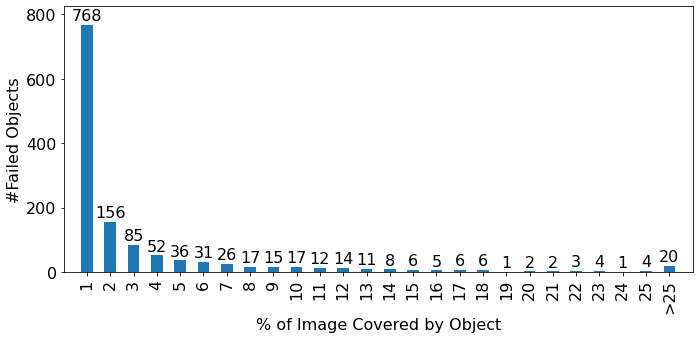

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
# Bring some raw data.
frequencies = x
# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = [f"{i+1}" for i in range(len(x)-1)]
x_labels.append(">25")

# Plot the figure.
plt.figure(figsize=(10, 5))
ax = freq_series.plot(kind="bar")
# ax.set_title("Failed Object Areas Distribution")

ax.set_xlabel("% of Image Covered by Object")
ax.set_ylabel("#Failed Objects")
ax.set_xticklabels(x_labels)
ax.set_ylim(0,825)
ax.set_xlim(-1,26)
rects = ax.patches

# Make some labels.
labels = [f"{x[i]}" for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.savefig("a.jpg")
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

In [3]:
def get_labels_with_sizes(x):
    obj_sizes = np.bincount(x.flatten())
    labels = np.nonzero(obj_sizes)[0].tolist()
    labels = [x for x in labels if x != 0]
    return labels, obj_sizes[labels].tolist()
def get_palette(num_cls):
    palette = np.zeros(3 * num_cls, dtype=np.int32)

    for j in range(0, num_cls):
        lab = j
        i = 0

        while lab > 0:
            palette[j*3 + 0] |= (((lab >> 0) & 1) << (7-i))
            palette[j*3 + 1] |= (((lab >> 1) & 1) << (7-i))
            palette[j*3 + 2] |= (((lab >> 2) & 1) << (7-i))
            i = i + 1
            lab >>= 3

    return palette.reshape((-1, 3))
color_map = get_palette(80)[1:]

In [8]:
import cv2
import os
import torch
import numpy as np
from detectron2.utils.colormap import colormap
# color_map = colormap(rgb=True, maximum=1)

sbd_path = "datasets/sbd/dataset/"
# print(os.path.exists(sbd_path + "img/2008_000051.jpg"))
image_id = "2008_000383"
image = cv2.imread(sbd_path + f"img/{image_id}.jpg")
print(image.shape)
# cv2.imshow("image", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
from scipy.io import loadmat
instances_mask = loadmat(str(sbd_path + f"inst/{image_id}.mat"))['GTinst'][0][0][0].astype(np.int32)
labels, _ = get_labels_with_sizes(instances_mask)
print(np.unique(instances_mask))
masks = []
import copy
print(labels)
for label in labels:
    
    temp_masks = copy.deepcopy(instances_mask)
    temp_masks[temp_masks != label] = 0
    temp_masks[temp_masks > 0] = 1
    # m = instances_mask == label
    masks.append(np.asarray(temp_masks, dtype =np.uint8))
masks = torch.from_numpy(np.stack(masks)).to(dtype = torch.uint8)
masks.shape


(375, 500, 3)
[0 1 2 3 4 5 6 7]
[1, 2, 3, 4, 5, 6, 7]


torch.Size([7, 375, 500])

In [9]:
from detectron2.utils.visualizer import Visualizer
image = cv2.imread(sbd_path + f"img/{image_id}.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualizer = Visualizer(image, metadata=None)
# pred_masks = F.resize(result_masks_for_vis.to(dtype=torch.uint8), image.shape[:2])
c = []
for i in range(masks.shape[0]):
    c.append(color_map[i]/255.0)
# pred_masks = np.asarray(pred_masks).astype(np.bool_)
vis = visualizer.overlay_instances(masks = masks, assigned_colors=c, alpha=0.70)
# [Optional] prepare labels

image = vis.get_image()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [66]:
filename = f"output/visual_results/{image_id}.png"
# im = cv2.cvtColor(image,  cv2.COLOR_RGB2BGR)
cv2.imwrite(filename, image)

True

In [3]:
from PIL import Image
davis_path = "datasets/DAVIS/DAVIS-2017-trainval/JPEGImages/480p/"
ann_path = "datasets/DAVIS/DAVIS-2017-trainval/Annotations/480p/"
image_id = "flamingo/00012"
image = cv2.imread(davis_path + f"{image_id}.jpg")
print(image.shape)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# from scipy.io import loadmat
# instances_mask = loadmat(str(sbd_path + f"inst/{image_id}.mat"))['GTinst'][0][0][0].astype(np.int32)
instances_mask = np.array(Image.open(ann_path+f"{image_id}.png").convert("P")).astype(np.uint8)
labels, _ = get_labels_with_sizes(instances_mask)
print(np.unique(instances_mask))
masks = []
import copy
print(labels)
for label in labels:
    
    temp_masks = copy.deepcopy(instances_mask)
    temp_masks[temp_masks != label] = 0
    temp_masks[temp_masks > 0] = 1
    # m = instances_mask == label
    masks.append(np.asarray(temp_masks, dtype =np.uint8))
masks = torch.from_numpy(np.stack(masks)).to(dtype = torch.uint8)
masks.shape

(480, 854, 3)
[0 1]
[1]


torch.Size([1, 480, 854])

In [4]:
from detectron2.utils.visualizer import Visualizer
image = cv2.imread(davis_path + f"{image_id}.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualizer = Visualizer(image, metadata=None)
# pred_masks = F.resize(result_masks_for_vis.to(dtype=torch.uint8), image.shape[:2])
c = []
for i in range(masks.shape[0]):
    c.append(color_map[2*(i)+2])
# pred_masks = np.asarray(pred_masks).astype(np.bool_)
vis = visualizer.overlay_instances(masks = masks, assigned_colors=c, alpha=0.65)
# [Optional] prepare labels

image = vis.get_image()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [80]:
filename = f"output/visual_results/lindy-hop.png"
# im = cv2.cvtColor(image,  cv2.COLOR_RGB2BGR)
cv2.imwrite(filename, image)

True

In [138]:
image =  cv2.imread("failed_v0.png", cv2.COLOR_BGR2RGB)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [139]:
h, w, _ = image.shape
print(image.shape)
h_new = int((2*h)/3)
w_new = int((2*w)/3)
im = cv2.resize(image,(w_new,h_new))
print(im.shape)

(501, 737, 3)
(334, 491, 3)


In [140]:
cv2.imshow("image", im)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [141]:
# im = cv2.cvtColor(im,  cv2.COLOR_RGB2BGR)
cv2.imwrite("new_failed_v0.png", im)

True